In [32]:
from qiskit import *
from qiskit import QuantumCircuit
import matplotlib.pyplot as plt
from qiskit_aer import Aer
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import PauliEvolutionGate
import numpy as np

Eq.(3):\
$\hat{H} = -J \sum_{l=0}^{L-2} \sum_{s=\uparrow, \downarrow} \left(a_{l,s}^{\dagger}a_{l+1,s} + a_{l+1,s}^{\dagger}a_{l,s} \right) + U \sum_{l=0}^{L-1} \hat{n}_{l,\uparrow}\hat{n}_{l,\downarrow}$

$\hat{H} = -J \sum_{i=0}^{2L-3}\left(a_{i}^{\dagger}a_{i+2} + a_{i+2}^{\dagger}a_{i} \right) + U \sum_{i=0}^{2L-1} \hat{n}_{i}\hat{n}_{i+1}$

$\hat{H} = -J \sum_{i=0}^{2L-3} \left(\left(\prod_{j=2L-1}^{i+1} \hat{Z}_{j} \right) \frac{\hat{X}_{i}-i\hat{Y}_{i}}{2} \otimes \left(\prod_{j=2L-1}^{i+1+2} \hat{Z}_{j} \right) \frac{\hat{X}_{i+2}+i\hat{Y}_{i+2}}{2}         + \left(\prod_{j=2L-1}^{i+1+2} \hat{Z}_{j} \right) \frac{\hat{X}_{i+2}-i\hat{Y}_{i+2}}{2} \otimes \left(\prod_{j=2L-1}^{i+1} \hat{Z}_{j} \right) \frac{\hat{X}_{i}+i\hat{Y}_{i}}{2}    \right)+ U \sum_{i=0}^{2L-1} \frac{\hat{1}_{i}\hat{1}_{i+1}-\hat{Z}_{i+1}-\hat{Z}_{i}+\hat{Z}_{i}\hat{Z}_{i+1}}{4} $

$\hat{H} = -J \sum_{i=0}^{2L-3} \left(\hat{Z}_{i+1} \hat{Z}_{i+2}  \frac{\hat{X}_{i}\hat{X}_{i+2}+\hat{Y}_{i}\hat{Y}_{i+2}}{2} \right)+ U \sum_{i=0}^{2L-1} \frac{\hat{1}_{i}\hat{1}_{i+1}-\hat{Z}_{i+1}-\hat{Z}_{i}+\hat{Z}_{i}\hat{Z}_{i+1}}{4} $

$\hat{H} = -J \sum_{i=0}^{2L-3} \left(\hat{Z}_{i+1}  (-i)*\frac{\hat{X}_{i}\hat{Y}_{i+2}-\hat{Y}_{i}\hat{X}_{i+2}}{2} \right)+ U \sum_{i=0}^{2L-1} \frac{\hat{1}_{i}\hat{1}_{i+1}-\hat{Z}_{i+1}-\hat{Z}_{i}+\hat{Z}_{i}\hat{Z}_{i+1}}{4} $

In [33]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import PauliEvolutionGate
import numpy as np

Qbits = 8
J = 1.0
U = 3.0

In [34]:
X = SparsePauliOp("X")
XZ = SparsePauliOp("XZ")
Z = SparsePauliOp("Z")
I = SparsePauliOp("I")

def exp_ZZXX(dt, i):
    label = ['I'] * Qbits
    label[i] = 'X'
    label[i+1] = 'Z'
    label[i+2] = 'Y'
    # label[i+3] = 'Z'
    pauli_label = ''.join(label[::-1])
    op = SparsePauliOp.from_list([(pauli_label, 1.0)])
    # label = ['I'] * Qbits
    # label[i+2] = 'Z'
    # pauli_label = ''.join(label[::-1])
    # op2=SparsePauliOp.from_list([(pauli_label, 1.0)])
    gate = PauliEvolutionGate(op, time=-J/2 * dt) #op2

    qc = QuantumCircuit(Qbits)
    qc.append(gate, range(Qbits))
    return qc

def exp_ZZYY(dt, i):
    label = ['I'] * Qbits
    label[i] = 'Y'
    label[i+1] = 'Z'
    label[i+2] = 'X'
    # label[i+3] = 'Z'
    pauli_label = ''.join(label[::-1])
    op = SparsePauliOp.from_list([(pauli_label, 1.0)])
    # label = ['I'] * Qbits
    # label[i+2] = 'Z'
    # pauli_label = ''.join(label[::-1])
    # op2=SparsePauliOp.from_list([(pauli_label, 1.0)])
    gate = PauliEvolutionGate(op, time=+J/2 * dt) #,op2

    qc = QuantumCircuit(Qbits)
    qc.append(gate, range(Qbits))
    return qc

def exp_11(dt, i):
    theta = -U * dt / 4
    qc = QuantumCircuit(Qbits)
    qc.global_phase += theta
    return qc

def exp_1Z(dt, i):
    label = ['I'] * Qbits
    label[i+1] = 'Z'
    pauli_label = ''.join(label[::-1])
    op = SparsePauliOp.from_list([(pauli_label, 1.0)])
    gate = PauliEvolutionGate(op, time=-U/4 * dt)

    qc = QuantumCircuit(Qbits)
    qc.append(gate, range(Qbits))
    return qc

def exp_Z1(dt, i):
    label = ['I'] * Qbits
    label[i] = 'Z'
    pauli_label = ''.join(label[::-1])
    op = SparsePauliOp.from_list([(pauli_label, 1.0)])
    gate = PauliEvolutionGate(op, time=-U/4 * dt)

    qc = QuantumCircuit(Qbits)
    qc.append(gate, range(Qbits))
    return qc

def exp_ZZ(dt, i):
    label = ['I'] * Qbits
    label[i] = 'Z'
    label[i+1] = 'Z'
    pauli_label = ''.join(label[::-1])
    op = SparsePauliOp.from_list([(pauli_label, 1.0)])
    gate = PauliEvolutionGate(op, time=+U/4 * dt)

    qc = QuantumCircuit(Qbits)
    qc.append(gate, range(Qbits))
    return qc


In [35]:
def trotter_step(dt):
    qc = QuantumCircuit(Qbits)
    L = Qbits // 2
    for i in range(2*L - 3):
        qc.compose(exp_ZZXX(dt, i), inplace=True)
        qc.compose(exp_ZZYY(dt, i), inplace=True)
    for i in range(2*L - 1):
        qc.compose(exp_11(dt, i), inplace=True)
        qc.compose(exp_1Z(dt, i), inplace=True)
        qc.compose(exp_Z1(dt, i), inplace=True)
        qc.compose(exp_ZZ(dt, i), inplace=True)
    return qc

def trotter_evolution(ini_state, t, Ns):
    dt = t / Ns
    qc_total = ini_state.copy()
    for it in range(Ns):
        qc_total.compose(trotter_step(dt), inplace=True)
    return qc_total

ini_state = QuantumCircuit(8)
ini_state.x([0,1,2,5])

# trotter_evolution(ini_state, 1, 3).draw(output='mpl')

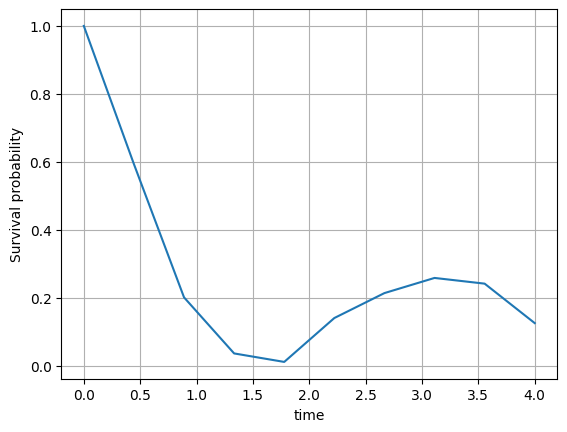

In [ ]:
initial_state = '00100111'
def P_meas(t, Ns, tot_shots=500):
    qc = trotter_evolution(ini_state, t, Ns)
    qc.measure_all()
    simulator = Aer.get_backend('aer_simulator')
    trans_circuit = transpile(qc, backend=simulator)
    job = simulator.run(trans_circuit, shots=tot_shots)
    counts = job.result().get_counts(qc)
    p = counts.get(initial_state, 0)/tot_shots
    return p

t = np.linspace(0, 4, 25)
p_array = []
for l in t:
    p_array.append(P_meas(l,3))

p_mean = []
p_std = []
p_values = []
for l in t:
    for j in range(5):
        p_values.append(P_meas(l,3))
    p_mean.append(np.mean(p_values))
    p_std.append(np.std(p_values))
    p_values = []
# plt.plot(t, p_mean)
plt.figure(figsize=(10, 6))
plt.errorbar(t, p_mean, p_std)
plt.xlabel('time')
plt.ylabel('Survival probability')
plt.grid(True)

Second task

Correct part that I need

In [37]:
def exp_ZZXX(dt, i):
    label = ['I'] * Qbits
    label[i] = 'X'
    label[i+1] = 'X'
    label[i+2] = 'Z'
    # label[i+3] = 'Z'
    pauli_label = ''.join(label[::-1])
    op = SparsePauliOp.from_list([(pauli_label, 1.0)])
    label = ['I'] * Qbits
    label[i+1] = 'Z'
    pauli_label = ''.join(label[::-1])
    op2=SparsePauliOp.from_list([(pauli_label, 1.0)])
    gate = PauliEvolutionGate([op,op2], time=-J/2 * dt)

    qc = QuantumCircuit(Qbits)
    qc.append(gate, range(Qbits))
    return qc

def exp_ZZYY(dt, i):
    label = ['I'] * Qbits
    label[i] = 'Y'
    label[i+1] = 'Y'
    label[i+2] = 'Z'
    # label[i+3] = 'Z'
    pauli_label = ''.join(label[::-1])
    op = SparsePauliOp.from_list([(pauli_label, 1.0)])
    label = ['I'] * Qbits
    label[i+1] = 'Z'
    pauli_label = ''.join(label[::-1])
    op2=SparsePauliOp.from_list([(pauli_label, 1.0)])
    gate = PauliEvolutionGate([op,op2], time=-J/2 * dt)

    qc = QuantumCircuit(Qbits)
    qc.append(gate, range(Qbits))
    return qc

def exp_11(dt, i):
    theta = -U * dt / 4
    qc = QuantumCircuit(Qbits)
    qc.global_phase += theta
    return qc

def exp_1Z(dt, i):
    label = ['I'] * Qbits
    label[i+1] = 'Z'
    pauli_label = ''.join(label[::-1])
    op = SparsePauliOp.from_list([(pauli_label, 1.0)])
    gate = PauliEvolutionGate(op, time=-U/4 * dt)

    qc = QuantumCircuit(Qbits)
    qc.append(gate, range(Qbits))
    return qc

def exp_Z1(dt, i):
    label = ['I'] * Qbits
    label[i] = 'Z'
    pauli_label = ''.join(label[::-1])
    op = SparsePauliOp.from_list([(pauli_label, 1.0)])
    gate = PauliEvolutionGate(op, time=-U/4 * dt)

    qc = QuantumCircuit(Qbits)
    qc.append(gate, range(Qbits))
    return qc

def exp_ZZ(dt, i):
    label = ['I'] * Qbits
    label[i] = 'Z'
    label[i+1] = 'Z'
    pauli_label = ''.join(label[::-1])
    op = SparsePauliOp.from_list([(pauli_label, 1.0)])
    gate = PauliEvolutionGate(op, time=+U/4 * dt)

    qc = QuantumCircuit(Qbits)
    qc.append(gate, range(Qbits))
    return qc

In [38]:
def trotter_step(dt):
    qc = QuantumCircuit(Qbits)
    L = Qbits // 2
    for i in range(2*L - 3):
        qc.compose(exp_ZZXX(dt, i), inplace=True)
        qc.compose(exp_ZZYY(dt, i), inplace=True)
    for i in range(2*L - 1):
        qc.compose(exp_11(dt, i), inplace=True)
        qc.compose(exp_1Z(dt, i), inplace=True)
        qc.compose(exp_Z1(dt, i), inplace=True)
        qc.compose(exp_ZZ(dt, i), inplace=True)
    return qc

def trotter_evolution(ini_state, t, Ns):
    dt = t / Ns
    qc_total = ini_state.copy()
    for it in range(Ns):
        qc_total.compose(trotter_step(dt), inplace=True)
    return qc_total

ini_state = QuantumCircuit(8)
ini_state.x([0,1,2,5])

trotter_evolution(ini_state, 1, 3)

In [39]:
def P_meas(t, Ns, tot_shots=500):
    qc = trotter_evolution(ini_state, t, Ns)
    qc.measure_all()
    simulator = Aer.get_backend('aer_simulator')
    trans_circuit = transpile(qc, backend=simulator)
    job = simulator.run(trans_circuit, shots=tot_shots)
    counts = job.result().get_counts(qc)
    p = counts.get(initial_state, 0)/tot_shots
    return p

Wrong part

In [40]:
from qiskit.quantum_info import Statevector, SparsePauliOp, Operator
from scipy.linalg import expm

def build_hamiltonian(Qbits, J, U):
    terms = []
    coeffs = []

    L = Qbits // 2

    for i in range(2*L - 3):
        #XX
        pauli = ['I'] * Qbits
        pauli[i] = 'X'
        pauli[i+1] = 'X'
        pauli[i+2] = 'Z'
        # pauli[i+3] = 'Z'
        terms.append(''.join(pauli[::-1]))
        coeffs.append(+J / 2)

        pauli = ['I'] * Qbits
        pauli[i+1] = 'Z'
        terms.append(''.join(pauli[::-1]))
        coeffs.append(+J / 2)


        #YY
        pauli[i] = 'Y'
        pauli[i+1] = 'Y'
        pauli[i+2] = 'Z'
        # pauli[i+3] = 'Z'
        terms.append(''.join(pauli[::-1]))
        coeffs.append(+J / 2)

        pauli = ['I'] * Qbits
        pauli[i+1] = 'Z'
        terms.append(''.join(pauli[::-1]))
        coeffs.append(+J / 2)

    for i in range(2*L - 1):
        #IZ
        pauli = ['I'] * Qbits
        pauli[i+1] = 'Z'
        terms.append(''.join(pauli[::-1]))
        coeffs.append(+U / 4)

        #ZI
        pauli = ['I'] * Qbits
        pauli[i] = 'Z'
        terms.append(''.join(pauli[::-1]))
        coeffs.append(+U / 4)

        #ZZ
        pauli[i+1] = 'Z'
        terms.append(''.join(pauli[::-1]))
        coeffs.append(-U / 4)

        #II
        terms.append('I' * Qbits)
        coeffs.append(-U / 4)

    H = SparsePauliOp(terms, coeffs)
    return H

def exact_evolution(H, psi0, t):
    H_mat = Operator(H).data
    U = expm(-1j * H_mat * t)
    psi_t = U @ psi0.data
    return psi_t

def survival_proba(psi0, psit):
    return np.abs(np.vdot(psi0.data, psit))**2


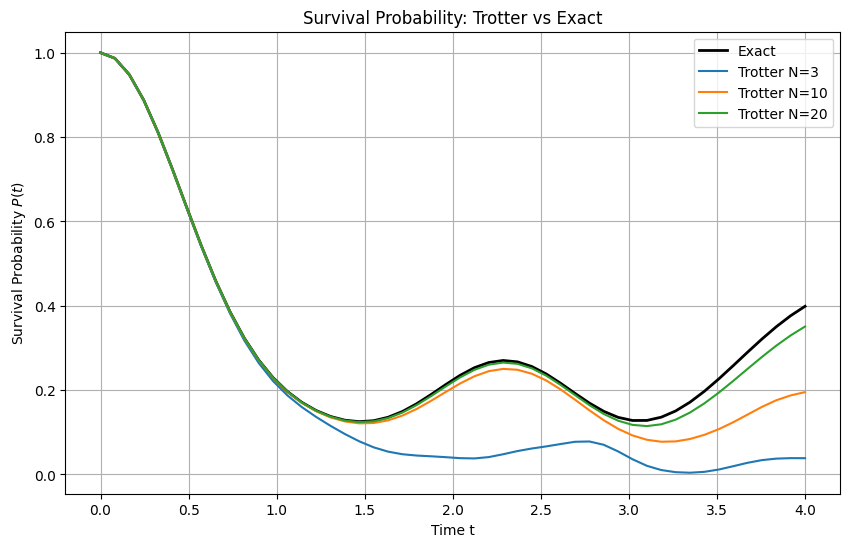

In [41]:
t_values = np.linspace(0, 4, 50)
trotter_steps_list = [3, 10, 20]

ini_state = QuantumCircuit(Qbits)
ini_state.x([0,1,2,5])
psi0 = Statevector.from_instruction(ini_state)
H = build_hamiltonian(Qbits, J, U)

plt.figure(figsize=(10, 6))
exact_probs = []

# Exakte Lösung
for t in t_values:
    psi_exact = exact_evolution(H, psi0, t)
    exact_probs.append(survival_proba(psi0, psi_exact))



plt.plot(t_values, exact_probs, label="Exact", color='black', linewidth=2)

# Trotter-Approximationen
for Ns in trotter_steps_list:
    trotter_probs = []
    for t in t_values:
        trotter_circuit = trotter_evolution(ini_state, t, Ns)
        psi_trotter = Statevector.from_instruction(trotter_circuit)
        trotter_probs.append(survival_proba(psi0, psi_trotter))

    plt.plot(t_values, trotter_probs, label=f"Trotter N={Ns}")

plt.xlabel("Time t")
plt.ylabel("Survival Probability $P(t)$")
plt.title("Survival Probability: Trotter vs Exact")
plt.legend()
plt.grid()
plt.show()